# Geometric Low-Rank Tensor Completion

**Published**: October 27, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**geotensor**](https://github.com/xinychen/geotensor/blob/master/GLTC+.ipynb).

----------------

Geometric Low-rank Tensor Completion (GLTC+) is an approach of reconstructing missing values within tensors. In particular, this approach could use the graphs as side information in form of regularizer.


## Motivation: Real-World Applications

In the field of computer vision, tensor completion problem arises as as many pixels may be missing in color images.

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

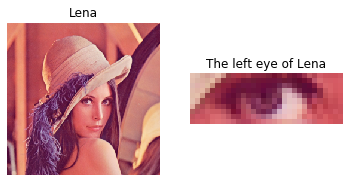

In [10]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('data/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye. The pixels of the left eye is apparent.

## Selected Images

We will carry out our image inpainting experiments on the following images.

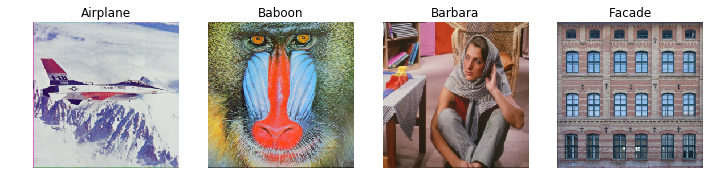

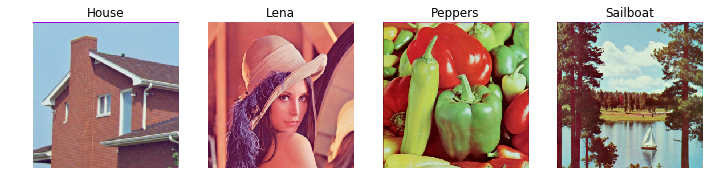

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Geometric Low-Rank Tensor Completion

We start by importing the necessary dependencies. We will make use of `numpy`.

In [1]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

In [2]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [3]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Soft Thresholding Method

Reference:

Ryan Tibshirani, 2015. Lecture on Proximal Gradient Descent. [[**link**](http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)]

In [80]:
def soft_thresholding(mat, lambda0): ## LSP regularization (nonconvex)
    theta = 0.00001
    gamma = min(lambda0 / theta, theta)
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - gamma
    pos = np.where(vec < 0)
    s[pos] = 0
    
    return np.matmul(np.matmul(u, np.diag(s)), v)

In [81]:
def GLTC(dense_tensor, sparse_tensor, beta, rho, maxiter):
    
    alpha = 1
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1, dim1))
    for i in range(dim1 - 1):
        D1[i+1, i] = -1
        D1[i+1, i+1] = 1
    D2 = np.zeros((dim2, dim2))
    for i in range(dim2 - 1):
        D2[i+1, i] = -1
        D2[i+1, i+1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(soft_thresholding(ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k), 
                                                      alpha / rho), np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                             + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            T[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

## Generalized singular value thresholding - Geman

In [99]:
def f_func(s_hat, s, lambda0, theta):
    return (0.5 * (s_hat - s)**2 + lambda0 * s_hat / (lambda0 + theta))

def delta_g(s_hat, lambda0, theta):
    return lambda0 * theta/(s_hat + theta)**2

def GSVT_Geman(mat, lambda0, theta):
#     theta = 0.001
#     gamma = min(lambda0 / theta, theta)
    gamma = 0
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    
    vec = s - gamma
    pos = np.where(vec < 0)
    s[pos] = 0
    positiveNum = len(s) - len(pos[0])
    for i in range(positiveNum):
        if delta_g(s[i], lambda0, theta) == 0:
            s_hat = s[i]
        else:
            s_hat = s[i]
            s_pre = s_hat + 100
            while abs(s_hat - s_pre) >= 0.0000000001:
                s_pre = s_hat
                s_hat = s[i] - delta_g(s_hat, lambda0, theta)
                if s_hat < 0:
                    s_hat = 0
                    break
        if s_hat != 0:
            if f_func(s_hat, s[i], lambda0, theta) > f_func(0, s[i], lambda0, theta):
                s_hat = 0
        s[i] = s_hat
    
    return np.matmul(np.matmul(u, np.diag(s)), v)

In [6]:
mat = 10 * np.random.randn(4,5)
mat_hat = GSVT_Geman(mat, 100, 0.001)
print(mat)
print()
print(mat_hat)

[[ -4.23766706 -13.34965414  -8.86336569  -2.82475737  -2.48135505]
 [ -8.86594911 -11.4114993    8.66907054  -0.6304231    2.75772101]
 [  7.55201698  -3.59567717  17.16783649  11.09604424  11.94215323]
 [-10.80779079  12.64610236  -3.92255465   5.90940365  -7.22896879]]

[[ -4.23780224 -13.34915294  -8.86257304  -2.82601315  -2.48139077]
 [ -8.86554486 -11.4116291    8.66847759  -0.62967643   2.75777024]
 [  7.55189701  -3.59543093  17.16824908  11.09509959  11.94207601]
 [-10.80761563  12.64619937  -3.92227171   5.90863909  -7.2289336 ]]


In [100]:
def GLTC_Geman(dense_tensor, sparse_tensor, beta, rho, maxiter, alpha, theta):
    
#     alpha = 50
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1, dim1))
    for i in range(dim1 - 1):
        D1[i+1, i] = -1
        D1[i+1, i+1] = 1
    D2 = np.zeros((dim2, dim2))
    for i in range(dim2 - 1):
        D2[i+1, i] = -1
        D2[i+1, i+1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(GSVT_Geman(ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k), 
                                                      alpha / rho, theta), np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                             + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            T[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

## Experiments on Color Images

In the following, we will illustrate the performance of image inpainting tasks using Geometric Low-rank Tensor Completion (GLTC) model on some color images.

We set the missing scenario as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we run the code for 10 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

### MAR

In [104]:
name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [108]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 5
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/GLTC_capped_L1_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)

6.864546485840011


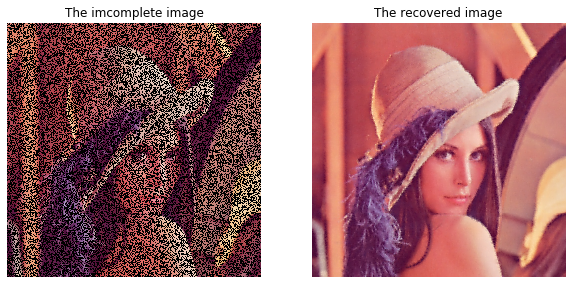

In [103]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

### R-MAR

In [123]:
name0 = ["lena"]
name = ["lena_rmar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [124]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
start_time = time.time()
theta = 0.1
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
# imageio.imwrite('data/GLTC_capped_L1_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)
run_time = time.time() - start_time
print('Time consumption: %d s'%(run_time))

8.20657682929766
Time consumption: 116 s


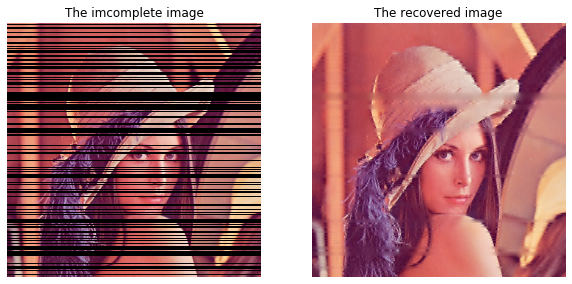

In [125]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

### C-MAR

In [127]:
name0 = ["lena"]
name = ["lena_cmar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [128]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
start_time = time.time()
theta = 0.1
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/GLTC_capped_L1_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)
run_time = time.time() - start_time
print('Time consumption: %d s'%(run_time))

10.811882589560692
Time consumption: 118 s


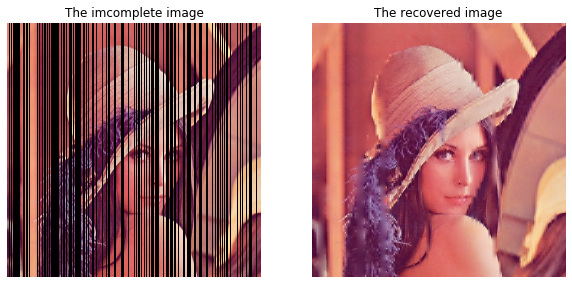

In [129]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

### RC-MAR

In [109]:
name0 = ["lena"]
name = ["lena_rcmar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [113]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 5
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/GLTC_capped_L1_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)

8.441913320020628


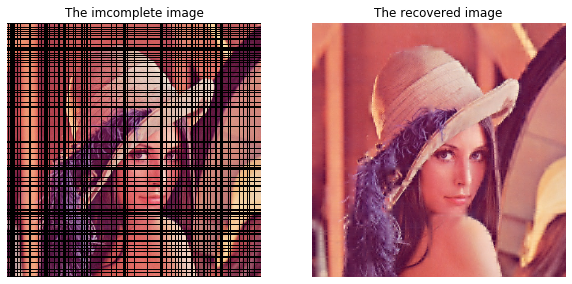

In [114]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

**Experiment results** of image inpainting using GLTC-Geman:

|  scenario | `regularizer`|`theta` | `alpha` |  `rho`  |`maxiter`|        `rse` |
|:----------|-------------:|-------:|--------:|--------:|--------:|-------------:|
|  **MAR**  |    **Geman** |  0.001 |    2000 |    0.01 |    1000 | **6.8889742**|
|  **MAR**  |    **Geman** |  0.001 |    3000 |    0.01 |    1000 | **6.8883511**|
|  **MAR**  |    **Geman** |  0.001 |    4000 |    0.01 |    1000 | **6.8874495**|
|  **MAR**  |    **Geman** |   0.01 |     400 |    0.01 |    1000 | **6.8874499**|
|  **MAR**  |    **Geman** |    0.1 |     400 |    0.01 |    1000 | **6.8646168**|
|  **MAR**  |    **Geman** |      1 |     400 |    0.01 |    1000 | **6.8054814**|
|  **MAR**  |    **Geman** |      2 |     400 |   0.005 |    1000 | **6.8053785**|
|  **MAR**  |    **Geman** |  **2** |  **400**| **0.01**|**1000** | **6.7925412**|
|  **MAR**  |    **Geman** |      2 |     400 |    0.02 |    1000 | **6.8056390**|
|  **MAR**  |    **Geman** |      3 |     400 |    0.01 |    1000 | **6.7939078**|
|  **MAR**  |    **Geman** |      5 |     400 |    0.01 |    1000 | **6.8089938**|
|  **MAR**  |    **Geman** |      1 |      10 |    0.02 |    1000 | **6.8823310**|
|  **MAR**  |    **Geman** |      2 |      10 |    0.02 |    1000 | **6.8767266**|
|  **MAR**  |    **Geman** |      3 |      10 |    0.02 |    1000 | **6.8718622**|
|  **MAR**  |    **Geman** |      4 |      10 |    0.02 |    1000 | **6.8672675**|
|  **MAR**  |    **Geman** |      5 |      10 |    0.02 |    1000 | **6.8645465**|
| **R-MAR** |    **Geman** |      2 |     400 |    0.01 |    1000 |    **8.41**  |
| **R-MAR** |    **Geman** |      2 |     100 |    0.01 |    1000 |**8.3176755** |
| **R-MAR** |    **Geman** |      2 |      50 |    0.01 |    1000 |**8.2778809** |
| **R-MAR** |    **Geman** |      2 |      10 |    0.01 |    1000 |**8.2324976** |
| **R-MAR** |    **Geman** |      2 |       1 |    0.01 |    1000 |**8.2082170** |
| **R-MAR** |    **Geman** |      2 |     0.5 |    0.01 |    1000 |**8.2035883** |
| **R-MAR** |    **Geman** |      2 |     0.1 |    0.01 |    1000 |**8.1974414** |
| **R-MAR** |    **Geman** |      2 |    0.08 |    0.01 |    1000 |**8.1969839** |
| **R-MAR** |    **Geman** |  **2** |**0.07** |**0.01** |**1000** |**8.1964873** |
| **R-MAR** |    **Geman** |      1 |    0.06 |    0.01 |    1000 |**8.1973143** |
| **R-MAR** |    **Geman** |      2 |    0.06 |    0.01 |    1000 |**8.1970678** |
| **R-MAR** |    **Geman** |      4 |    0.06 |    0.01 |    1000 |**8.1974532** |
| **R-MAR** |    **Geman** |      2 |    0.06 |   0.001 |    1000 |**8.2044398** |
| **R-MAR** |    **Geman** |      2 |    0.05 |    0.01 |    1000 |**8.1977935** |
| **R-MAR** |    **Geman** |    0.1 |      10 |    0.01 |    1000 |**8.2065768** |
| **C-MAR** |    **Geman** |      2 |    0.05 |    0.01 |    1000 |**10.8009175**|
| **C-MAR** |    **Geman** |      2 |    0.02 |    0.01 |    1000 |**10.8004753**|
| **C-MAR** |    **Geman** |      3 |    0.01 |    0.01 |    1000 |**10.8004462**|
| **C-MAR** |    **Geman** |      2 |    0.01 |    0.01 |    1000 |**10.8002521**|
| **C-MAR** |    **Geman** |      1 |    0.01 |    0.01 |    1000 |**10.8005837**|
| **C-MAR** |    **Geman** |      2 |     0.1 |    0.01 |    1000 |**10.8017131**|
| **C-MAR** |    **Geman** |      2 |       1 |    0.01 |    1000 |**10.8145074**|
| **C-MAR** |    **Geman** |      2 |      10 |    0.01 |    1000 |**10.8640825**|
| **C-MAR** |    **Geman** |    0.1 |      10 |    0.01 |    1000 |**10.8118826**|
| **C-MAR** |    **Geman** |      1 |      10 |    0.01 |    1000 |**10.8458683**|
| **C-MAR** |    **Geman** |      5 |      10 |    0.01 |    1000 |**10.8852486**|
| **RC-MAR** |    **Geman** |     2 |      10 |    0.01 |    1000 |**8.42810301**|
| **RC-MAR** |    **Geman** |     5 |      10 |    0.01 |    1000 |**8.44191332**|
| **RC-MAR** |    **Geman** |     2 |      50 |    0.01 |    1000 |**8.46010942**|

Table 1-1: **Experiment results** (RSE performance) of image inpainting for `lena` and `peppers` using GLTC (Capped-$\ell_1$):

|  Images   |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **lena**  |     6.79      |       8.41     |   11.02   |      8.51      |
|**peppers**|     7.80      |      11.22     |   12.15   |      9.73      |


### Whole Performance

We choose the images of `house`, `lena`, `peppers`, and `sailboat` for evaluation.

#### MAR (Missing at random)

In [71]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 2
alpha = 400
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                print('Image: %s, Missing level: %d, iteration: %d'%(im[ima], (missing + 1), (it + 1)))

Image: lena, Missing level: 1, iteration: 10
Image: lena, Missing level: 1, iteration: 20
Image: lena, Missing level: 1, iteration: 30
Image: lena, Missing level: 1, iteration: 40
Image: lena, Missing level: 1, iteration: 50
Image: lena, Missing level: 2, iteration: 10
Image: lena, Missing level: 2, iteration: 20
Image: lena, Missing level: 2, iteration: 30
Image: lena, Missing level: 2, iteration: 40
Image: lena, Missing level: 2, iteration: 50
Image: lena, Missing level: 3, iteration: 10
Image: lena, Missing level: 3, iteration: 20
Image: lena, Missing level: 3, iteration: 30
Image: lena, Missing level: 3, iteration: 40
Image: lena, Missing level: 3, iteration: 50
Image: peppers, Missing level: 1, iteration: 10
Image: peppers, Missing level: 1, iteration: 20
Image: peppers, Missing level: 1, iteration: 30
Image: peppers, Missing level: 1, iteration: 40
Image: peppers, Missing level: 1, iteration: 50
Image: peppers, Missing level: 2, iteration: 10
Image: peppers, Missing level: 2, ite

In [72]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)

[[6.05795294 6.8574904  8.07404317]
 [6.67790742 7.71018437 9.33003636]]

[[0.07253212 0.07495686 0.07905918]
 [0.10194032 0.08194963 0.09235785]]


#### R-MAR (Row-wise missing at random)

In [12]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

theta = 2
alpha = 0.07
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                print('Image: %s, missing level: %d, iteration: %d'%(im[ima], (missing + 1), (it + 1)))

Image: lena, missing level: 1, iteration: 10
Image: lena, missing level: 1, iteration: 20
Image: lena, missing level: 1, iteration: 30
Image: lena, missing level: 1, iteration: 40
Image: lena, missing level: 1, iteration: 50
Image: lena, missing level: 2, iteration: 10
Image: lena, missing level: 2, iteration: 20
Image: lena, missing level: 2, iteration: 30
Image: lena, missing level: 2, iteration: 40
Image: lena, missing level: 2, iteration: 50
Image: lena, missing level: 3, iteration: 10
Image: lena, missing level: 3, iteration: 20
Image: lena, missing level: 3, iteration: 30
Image: lena, missing level: 3, iteration: 40
Image: lena, missing level: 3, iteration: 50
Image: peppers, missing level: 1, iteration: 10
Image: peppers, missing level: 1, iteration: 20
Image: peppers, missing level: 1, iteration: 30
Image: peppers, missing level: 1, iteration: 40
Image: peppers, missing level: 1, iteration: 50
Image: peppers, missing level: 2, iteration: 10
Image: peppers, missing level: 2, ite

In [14]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)

[[ 7.1200512   8.60556618 12.89038433]
 [ 9.23879136 11.24489482 16.34365288]]

[[0.39045216 0.79627458 3.47344129]
 [0.77097279 0.92124126 3.38134472]]


#### C-MAR (Column-wise missing at random)

In [16]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [17]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)

[[ 8.56348962 10.24430977 15.07030053]
 [ 9.49776294 11.48160295 18.02077292]]


#### RC-MAR

In [18]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [19]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)

[[ 7.54142829  8.44481248 10.1913689 ]
 [ 8.78914587 10.16310856 12.04637675]]


Table 1-2: **Experiment results** (RSE performance) of image inpainting on two color images using GLTC (Geman):

|   -  | Scenario |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:-----|:----------|--------------:|---------------:|----------:|---------------:|
| **Lena** | **30%**   |     6.06$\pm$0.07      |       7.12$\pm$0.39     |  ~     |       ~     |
|   -  | **50%**   |     6.86$\pm$0.07      |      8.61$\pm$0.79     | ~     |       ~     |
|   -  | **70%**   |     8.07$\pm$0.08      |      12.89$\pm$3.47     |   ~     |      ~     |
| **Peppers** | **30%**   |     6.68$\pm$0.10      |       9.24$\pm$0.77     |  ~     |       ~     |
|   -  | **50%**   |     7.71$\pm$0.08      |      11.24$\pm$0.92     | ~     |       ~     |
|   -  | **70%**   |     9.33$\pm$0.09      |      16.34$\pm$3.38     | ~     |      ~     |